In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

#getting the data set
data=pd.read_csv('brain_stroke.csv',index_col=0)
data.head(-5)
#print(data)
#print(data.isna().sum())
#print(data.info())

# Importing LabelEncoder
from sklearn.preprocessing import LabelEncoder
# Instantiating LabelEncoder
le=LabelEncoder()
# Iterating over all the values of each column and extract their dtypes
for col in data.columns.to_numpy():
    # Comparing if the dtype is object
    if data[col].dtypes in ('object','category'):
    # Using LabelEncoder to do the numeric transformation
        data[col]=le.fit_transform(data[col].astype(str))


#establishing the training set and the test set
X=data.drop(["stroke"],axis=1)
y=data["stroke"]

scaler = MinMaxScaler()
X= scaler.fit_transform(X)

#take number of features equal to number of components 
ica = FastICA(n_components=6, random_state=42,max_iter=300).fit(X)
X_red=ica.transform(X)
mean=np.mean(kurtosis(X_red, fisher=False))
print(mean)
print(kurtosis(X_red, fisher=False))
X_red_new=np.array([X_red[:,0],X_red[:,4],X_red[:,5]])
X_red_new=np.transpose(X_red_new)
print(X_red_new)

4.537785493048641
[ 8.39722268  1.50518578  1.00140517  1.74652264  2.32161485 12.25476185]
[[-0.00678513  0.00676272 -0.06276358]
 [-0.00868738  0.00099284 -0.05339431]
 [-0.00351234 -0.0041573  -0.00311323]
 ...
 [ 0.0411313   0.01055103  0.01556613]
 [-0.00583436 -0.00715666  0.00771607]
 [ 0.04358086 -0.00072955  0.00728059]]


C:\Users\Batuhan\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


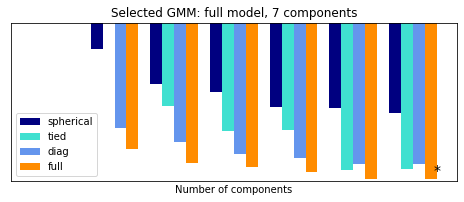

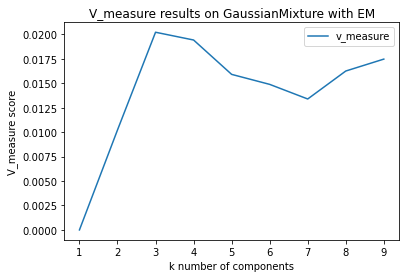

In [3]:
X=X_red_new
lowest_bic = np.infty
bic = []
n_components_range = range(1, 8)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type,random_state=42
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)
'''
# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
'''
plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

'''
metrics.v_measure_score(labels_true, labels_pred)
'''
labels_true=y
v_measure_list=[]
for k in range(1,10):
    clusterer = mixture.GaussianMixture(n_components=k, covariance_type="spherical",random_state=42)
    labels_pred = clusterer.fit_predict(X)
    score=metrics.v_measure_score(labels_true, clusterer.predict(X))
    v_measure_list.append(score)

k_clusters=[k for k in range(1,10)]
fig, ax1=plt.subplots()
ax1.plot(k_clusters, v_measure_list,label="v_measure")
ax1.set_title('V_measure results on GaussianMixture with EM')
ax1.set_xlabel('k number of components')
ax1.set_ylabel('V_measure score')
ax1.legend()
plt.show()